In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import os
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

data_folder = Path("../../data")

# Necessary for notebook to see src package
import sys
sys.path.append('../..')

Device: cuda


# Download Dataset into Memory

In [16]:
dataset = pd.read_csv(data_folder / 'Covertype' / 'data.csv')
dataset.head(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2720,36,17,30,0,1308,217,201,114,2255,...,0,0,0,0,0,0,0,0,0,5
1,2579,293,18,323,109,648,167,233,206,577,...,0,0,0,0,0,0,0,0,0,6
2,3021,0,4,234,39,228,214,232,156,579,...,0,0,0,0,0,0,0,0,0,1
3,2489,19,32,212,88,1159,179,157,97,882,...,0,0,0,0,0,0,0,0,0,3
4,2655,216,21,192,139,1758,193,254,190,234,...,0,0,0,0,0,0,0,0,0,3
5,2988,252,12,541,82,5699,193,248,193,4878,...,0,0,0,0,0,0,0,0,0,2
6,2876,51,15,361,57,1574,226,207,110,2814,...,0,1,0,0,0,0,0,0,0,2
7,2931,318,12,532,31,2741,187,229,181,1277,...,0,0,0,0,0,0,0,0,0,2
8,3191,70,5,402,59,3161,225,230,140,3515,...,0,0,0,0,0,0,0,0,0,1
9,3015,117,13,679,-47,1114,241,228,114,1199,...,0,0,0,0,0,0,0,0,0,2


# Missing Values

There is no missing values in CTABGAN+ datasets but i am just making sure

In [17]:
print(f'Missing values in the dataset: {dataset.isna().sum().sum()}')

Missing values in the dataset: 0


# General Info

- Column `education-num` had the same info as the `education` column so it was safe an beneficial to drop that column 
- We can see that the columns _workclass_, _education_, _marital-status_, _occupation_, _relationship_, _race_, _gender_, _native-country_, _income_ are categorical variables.

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           50000 non-null  int64
 1   Aspect                              50000 non-null  int64
 2   Slope                               50000 non-null  int64
 3   Horizontal_Distance_To_Hydrology    50000 non-null  int64
 4   Vertical_Distance_To_Hydrology      50000 non-null  int64
 5   Horizontal_Distance_To_Roadways     50000 non-null  int64
 6   Hillshade_9am                       50000 non-null  int64
 7   Hillshade_Noon                      50000 non-null  int64
 8   Hillshade_3pm                       50000 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  50000 non-null  int64
 10  Wilderness_Area1                    50000 non-null  int64
 11  Wilderness_Area2                    50000 non-null  int64
 12  Wild

In [19]:
# No String Columns and most of the categorical columns are binary

string_columns = [col for col in dataset.columns if dataset[col].dtype == 'object']
other_columns = [col for col in dataset.columns if col not in string_columns]

print(f'String cols: {string_columns}')
print(f'Other cols: {other_columns}')

String cols: []
Other cols: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']


# Other Columns and Their Cardinalities

In [20]:
for col in other_columns:
    print(f'{col:<20}: {dataset[col].dtype}({dataset[col].unique().__len__()})')

Elevation           : int64(1686)
Aspect              : int64(361)
Slope               : int64(54)
Horizontal_Distance_To_Hydrology: int64(469)
Vertical_Distance_To_Hydrology: int64(533)
Horizontal_Distance_To_Roadways: int64(5061)
Hillshade_9am       : int64(189)
Hillshade_Noon      : int64(147)
Hillshade_3pm       : int64(250)
Horizontal_Distance_To_Fire_Points: int64(4756)
Wilderness_Area1    : int64(2)
Wilderness_Area2    : int64(2)
Wilderness_Area3    : int64(2)
Wilderness_Area4    : int64(2)
Soil_Type1          : int64(2)
Soil_Type2          : int64(2)
Soil_Type3          : int64(2)
Soil_Type4          : int64(2)
Soil_Type5          : int64(2)
Soil_Type6          : int64(2)
Soil_Type7          : int64(2)
Soil_Type8          : int64(2)
Soil_Type9          : int64(2)
Soil_Type10         : int64(2)
Soil_Type11         : int64(2)
Soil_Type12         : int64(2)
Soil_Type13         : int64(2)
Soil_Type14         : int64(2)
Soil_Type15         : int64(1)
Soil_Type16         : int64(2)
S

# Categorical and Numerical Columns

In [21]:
binary_columns = [col for col in other_columns if dataset[col].unique().__len__() <= 2]
multi_class_columns = [col for col in other_columns if (dataset[col].unique().__len__() > 2) and (dataset[col].unique().__len__() <= 10) ]
numeric_columns = [col for col in other_columns if col not in binary_columns and col not in multi_class_columns]

binary_columns = binary_columns + [col for col in string_columns if dataset[col].unique().__len__() <= 2]
multi_class_columns = multi_class_columns + [col for col in string_columns if (dataset[col].unique().__len__() > 2)]

print(f'binary_columns({len(binary_columns)}): {binary_columns}')
print(f'multi_class_columns({len(multi_class_columns)}): {multi_class_columns}')
print(f'numeric_columns({len(numeric_columns)}): {numeric_columns}')

binary_columns(44): ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
multi_class_columns(1): ['Cover_Type']
numeric_columns(10): ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


# Single Mode Gaussian Variables 

Here we can see that `age` is a single mode Gaussion variable

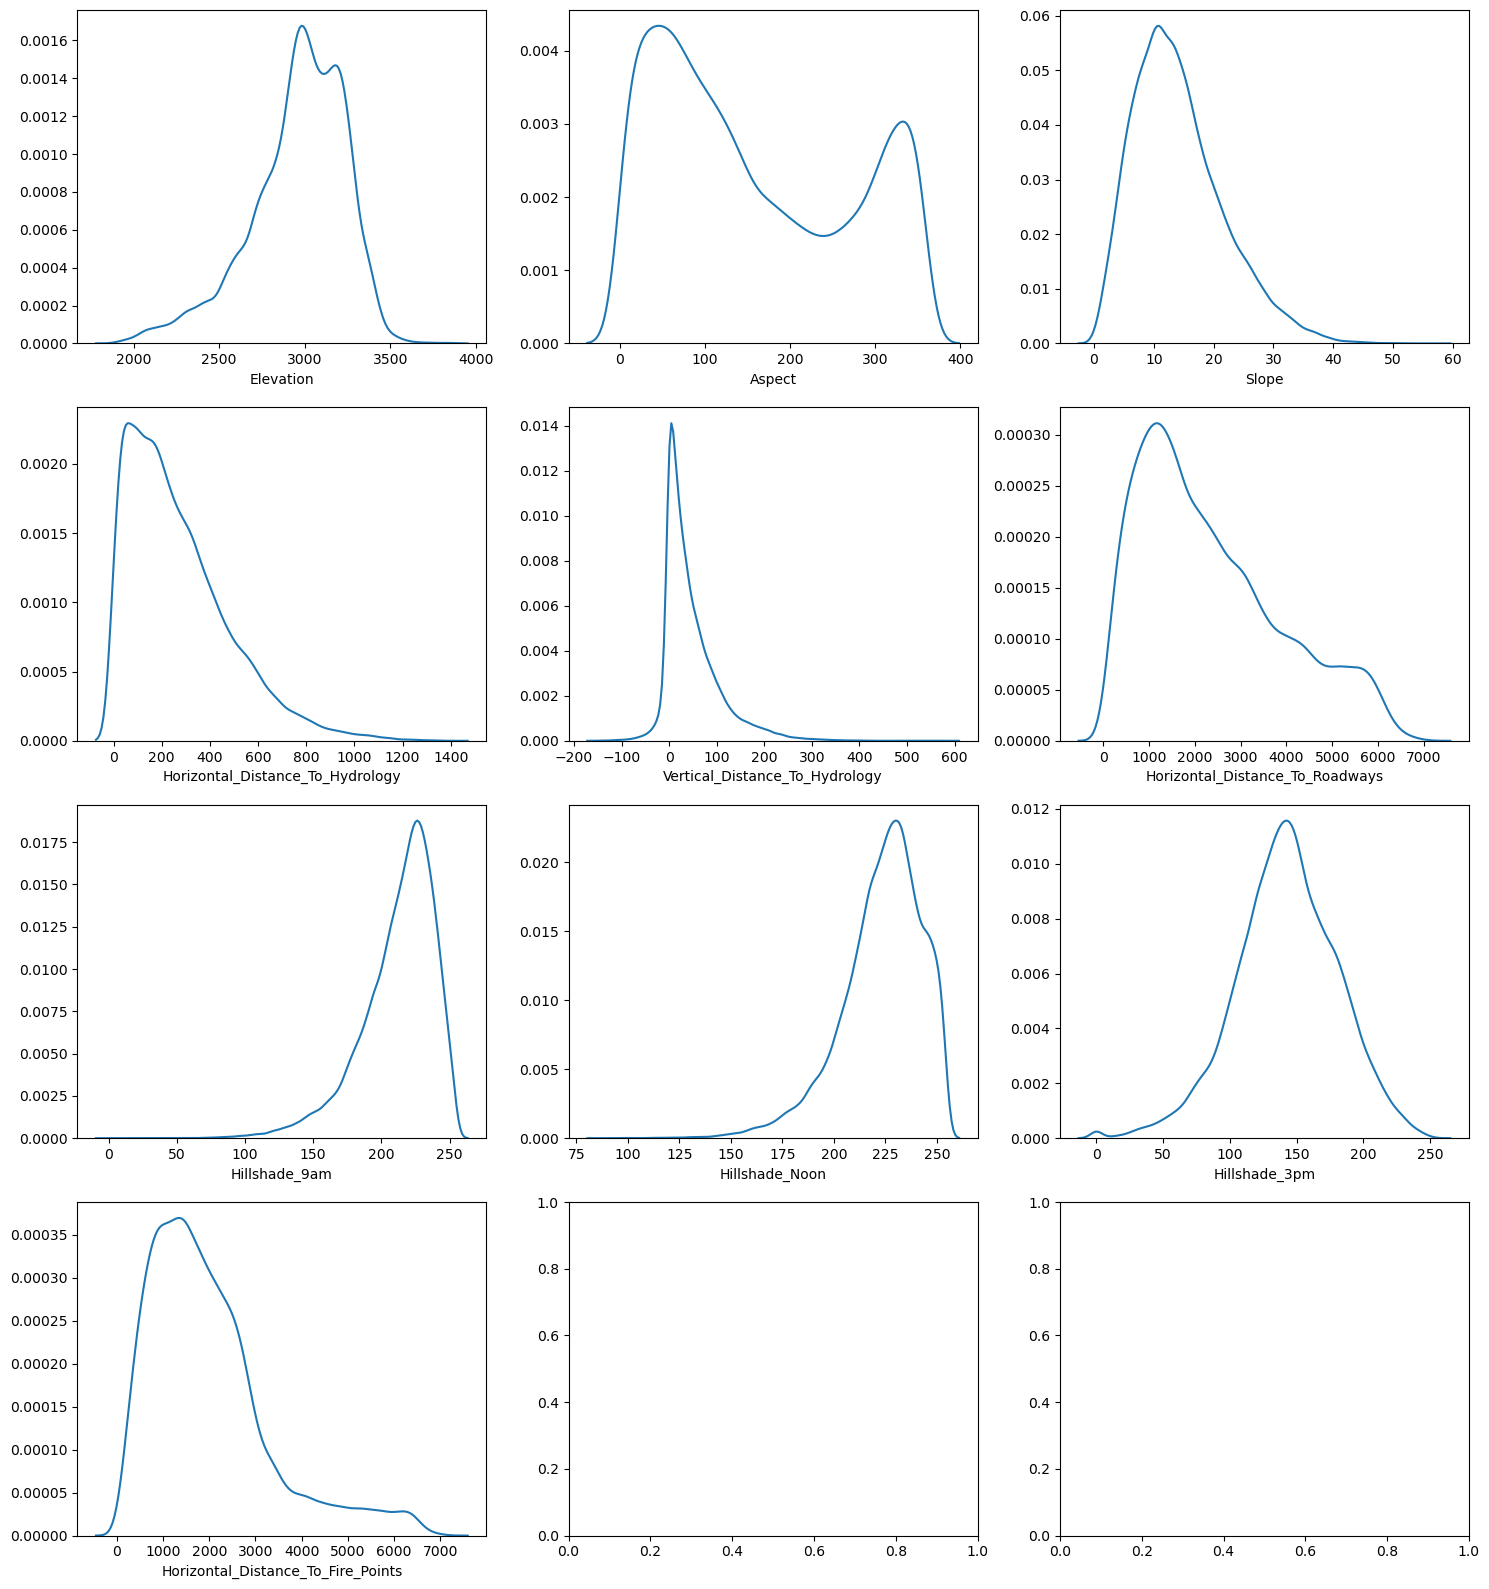

In [22]:
import math
from matplotlib.axes import Axes

fig = plt.figure(figsize=(15, math.ceil(len(numeric_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(numeric_columns) / 3.0), ncols=3)

for col_index in range(len(numeric_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.kdeplot(
        data=dataset[numeric_columns[col_index]],
        ax=current_ax,
        common_norm=False,
    )
    current_ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Mixed Type Variables

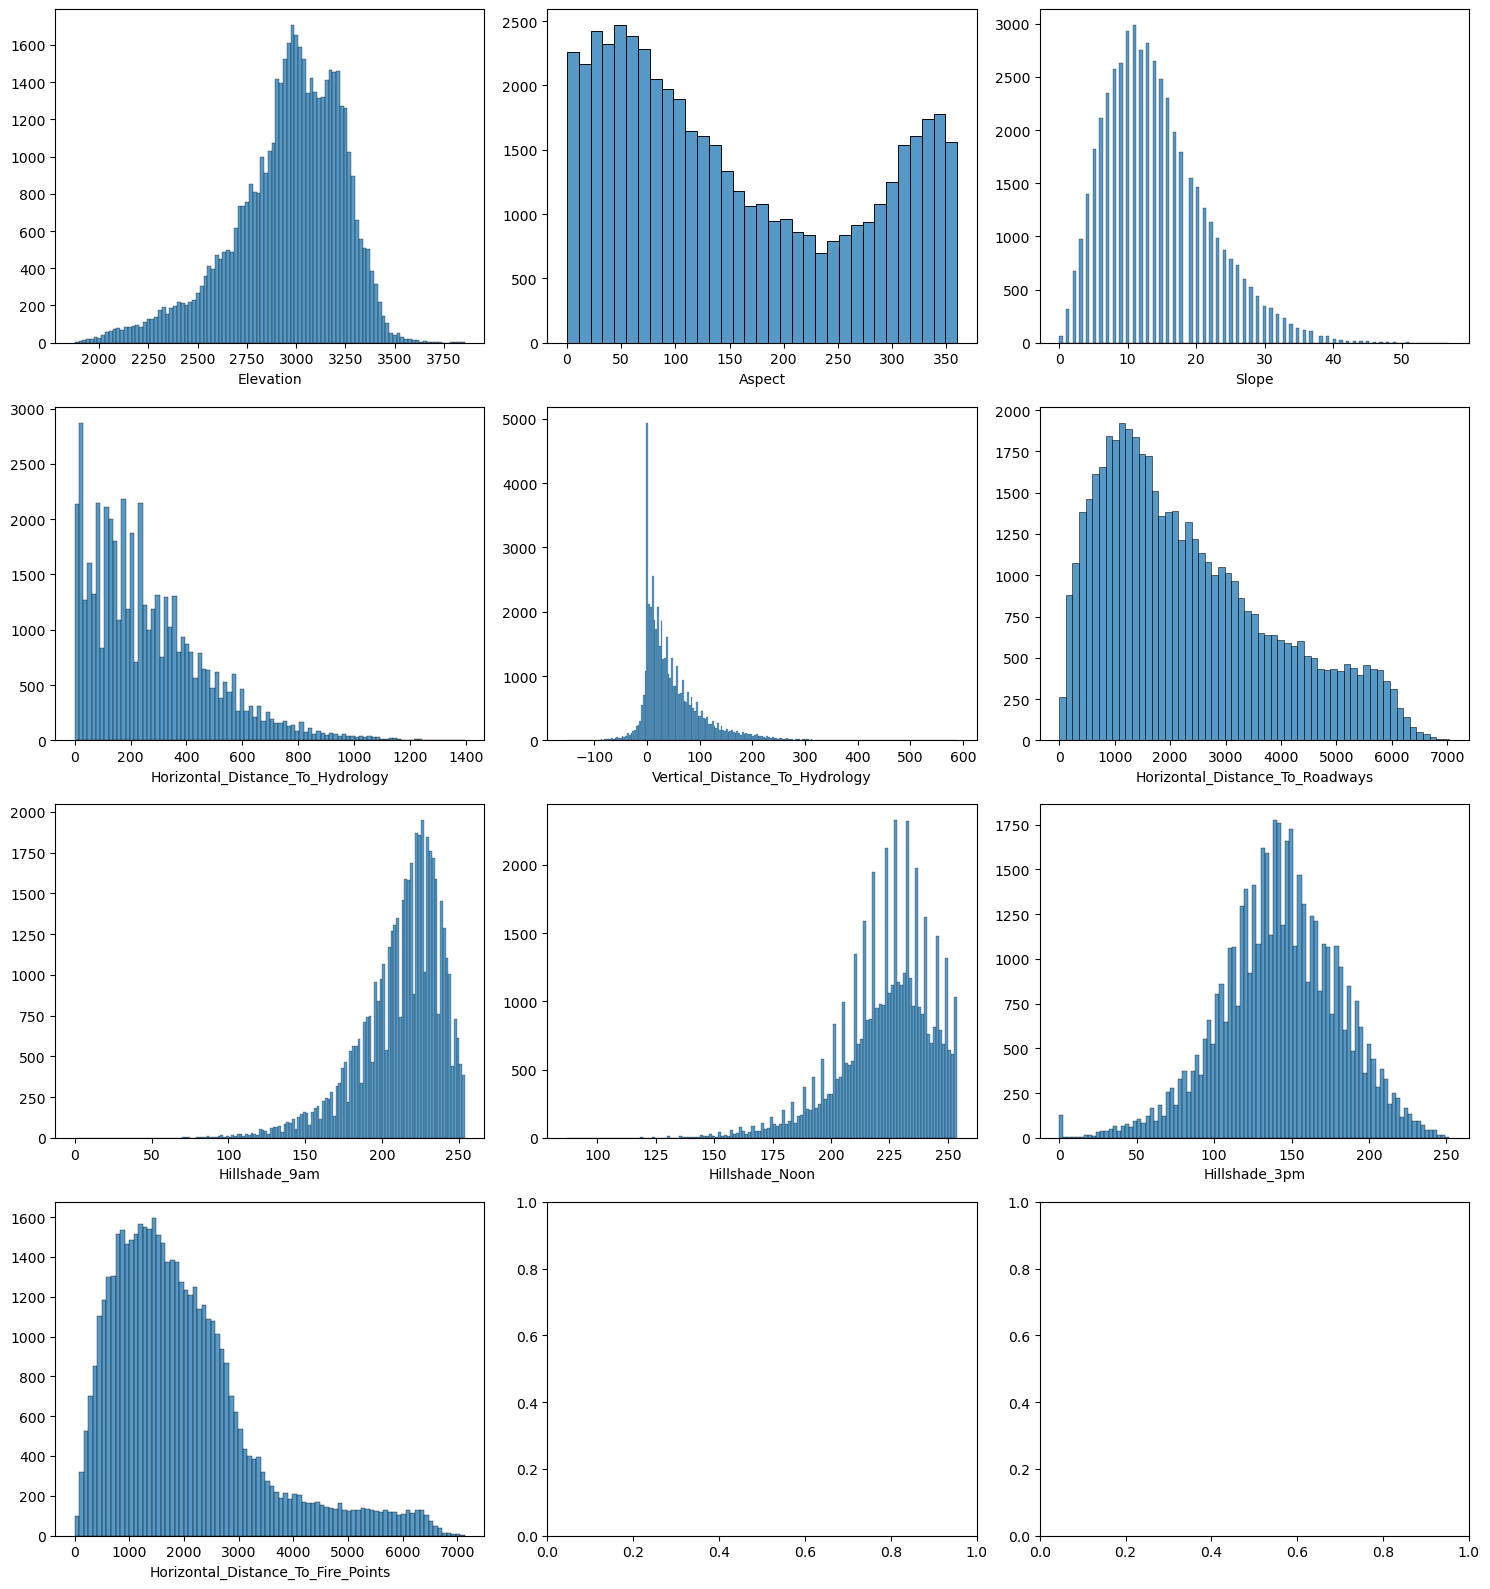

In [23]:
import math
from matplotlib.axes import Axes

fig = plt.figure(figsize=(15, math.ceil(len(numeric_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(numeric_columns) / 3.0), ncols=3)

for col_index in range(len(numeric_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.histplot(
        data=dataset[numeric_columns[col_index]],
        ax=current_ax,
    )
    current_ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [24]:
dataset['Vertical_Distance_To_Hydrology'].mode()

0    0
Name: Vertical_Distance_To_Hydrology, dtype: int64

# Categorical Variables

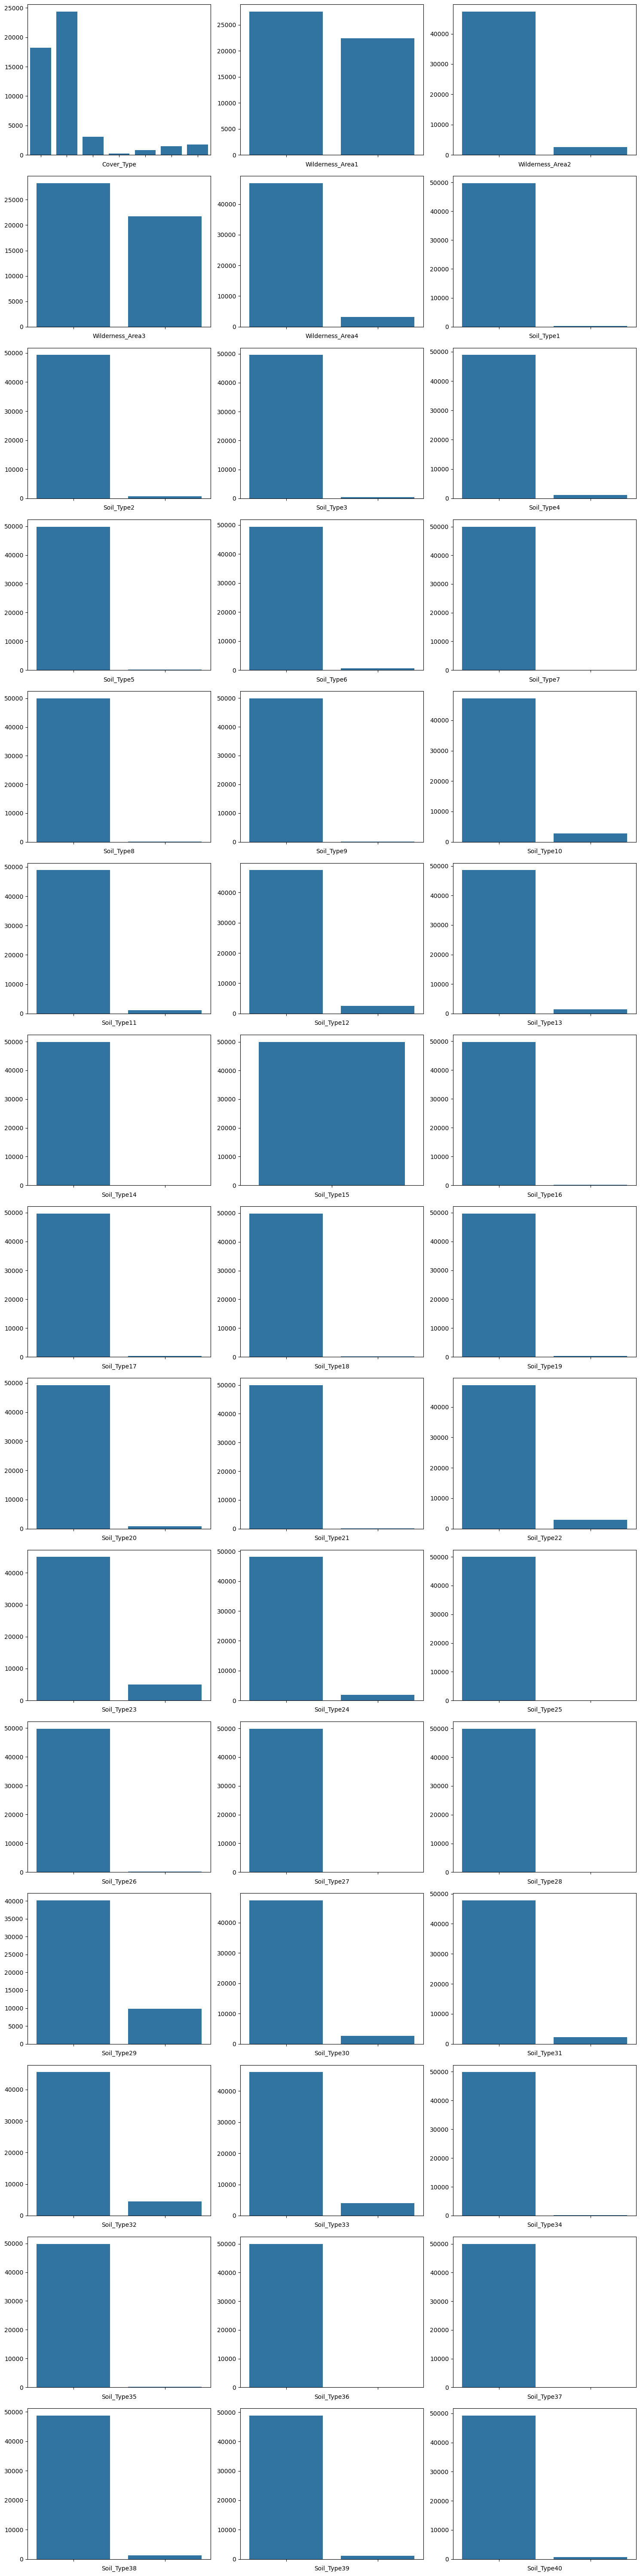

In [25]:
import math
from matplotlib.axes import Axes

categorical_columns = multi_class_columns + binary_columns

fig = plt.figure(figsize=(15, math.ceil(len(categorical_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(categorical_columns) / 3.0), ncols=3)

for col_index in range(len(categorical_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.countplot(
        data=dataset,
        x=categorical_columns[col_index],
        ax=current_ax,
    )
    current_ax.set_ylabel('')
    current_ax.set_xticklabels([])
plt.tight_layout()
plt.show()

The final argumnets for the dataset is:

In [26]:
import json

args = {
    'missing_values': False,
    'categorical_columns' :categorical_columns,
    'log_columns': [],
    'mixed_columns': {'Vertical_Distance_To_Hydrology': 0.0}, # Mixed Type
    'general_columns': [],                                 # Single Gaussian Mode or Highly cardinal data
    'non_categorical_columns': [],
    'integer_columns': numeric_columns,
    'problem_type': 'classification',
    'target': 'Covertype'
}

with open(data_folder / 'Covertype' / 'metadata.json', 'w+') as file:
    json.dump(args, file, indent=4)

In [27]:
args

{'missing_values': False,
 'categorical_columns': ['Cover_Type',
  'Wilderness_Area1',
  'Wilderness_Area2',
  'Wilderness_Area3',
  'Wilderness_Area4',
  'Soil_Type1',
  'Soil_Type2',
  'Soil_Type3',
  'Soil_Type4',
  'Soil_Type5',
  'Soil_Type6',
  'Soil_Type7',
  'Soil_Type8',
  'Soil_Type9',
  'Soil_Type10',
  'Soil_Type11',
  'Soil_Type12',
  'Soil_Type13',
  'Soil_Type14',
  'Soil_Type15',
  'Soil_Type16',
  'Soil_Type17',
  'Soil_Type18',
  'Soil_Type19',
  'Soil_Type20',
  'Soil_Type21',
  'Soil_Type22',
  'Soil_Type23',
  'Soil_Type24',
  'Soil_Type25',
  'Soil_Type26',
  'Soil_Type27',
  'Soil_Type28',
  'Soil_Type29',
  'Soil_Type30',
  'Soil_Type31',
  'Soil_Type32',
  'Soil_Type33',
  'Soil_Type34',
  'Soil_Type35',
  'Soil_Type36',
  'Soil_Type37',
  'Soil_Type38',
  'Soil_Type39',
  'Soil_Type40'],
 'log_columns': [],
 'mixed_columns': {'Vertical_Distance_To_Hydrology': 0.0},
 'general_columns': [],
 'non_categorical_columns': [],
 'integer_columns': ['Elevation',
  'Asp